Naive Bayes is an extremely simple classification scheme that often works amazingly well in practice.  We'll apply it to a very simple dataset having to do with the survival of lobsters.  We'll begin by importing the numerical library numpy, which allows us to manipulate arrays, the data management library pandas, and the plotting utility matplotlib


In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,15)
mpl.rcParams['font.size'] = 20
import matplotlib.pyplot as plt

data = pd.read_csv('datasets/lobster_survive.dat',header=0,sep=r"\s{2,}")
X = data['Len'].values.astype(float)
Y = data['Survive'].values.astype(float)
m = len(Y) #Number of da

N_classes = 2

plt.hist(X[Y==0],label='Dead Lobster',bins=np.arange(25,60,3),histtype='step')
plt.hist(X[Y==1],label='Alive Lobster',bins=np.arange(25,60,3),histtype='step')
plt.xlabel('Lobster Size')
plt.ylabel('Count')
plt.legend()
plt.show()


/home/brinkerhoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


<Figure size 1800x1500 with 1 Axes>

The method works in a two step processs: First, for a set of classes $C_k \in \{C_1,C_2,\ldots,C_N\}$, where $N$ is the number of possible class labels (2 in this case), use Bayes' rule to generate a probability that a data instance with a set of features $x_j$ belongs to each class, given a set of training data $D=(X,Y)$.  In step two, assign the class label with the highest probability to that data instance.  For each class $C_k$, we can use Bayes' rule to determine the probability:
$$ 
P(C_k|x_j,D) \propto P(x_j|C_k) P(C_k|D).
$$
However, this equation implies that we have to compute the joint probability of $\mathbf{x}$, where there could be some complicated correlations between features.  We can simplify this model by assuming that all of the features ($x_i \in \mathbf{X}$) are independent, or
$$ P(\mathbf{x}|D,C_k) \approx \prod_{j=1}^n P(x_j|D,C_k), $$
where $n$ is the number of features in a data instance.  This is the so-called *naive Bayes* assumption, naive because it assumes no correlation between features.  This leads to the simpler model:
$$
P(C_k|\mathbf{x},D) \propto P(C_k|D) \prod_{j=1}^n P(x_j|D,C_k).
$$

Now, we need to specify the distributions for the class prior $P(C_k|D)$ and class likelihoods $P(x_i|D,C_k)$.  We can model the prior probability as a Bernoulli distribution 
$$P(C=C_k|D) = \eta_k, $$
where $\eta_k$ is the probability that we would label the feature $\mathbf{x}$ as class $C_k$, before having seen any of the values in $\mathbf{x}$.  There are different options here.  We could say that all classes are equally likely, so $\eta=1/N$.  A more common practice is to estimate $\eta$ as the maximum likelihood value from the training data $D$, which for a Bernoulli distribution is 
$$
\eta_k = \frac{\sum_{i=1}^n [C = C_k]}{\sum_{i=1}^n},
$$
or the total proportion of the training data where the label is $C_k$.  Note the use of the [Iverson Bracket](https://en.wikipedia.org/wiki/Iverson_bracket) in the above definition.



In [2]:
etas = np.zeros((N_classes))
for C_k in [0,1]:
    etas[C_k] = len(Y[Y==C_k])/len(Y)
print(etas) #About fifty/fifty : a balanced dataset

[0.50314465 0.49685535]


For the likelihood, since we're considering continuous features, it makes sense to use a continous likelihood function.  While there are many options, a normal distribution should do the trick.  However, we need to use the training data to estimate the parameters of this normal distribution.  This is similar to what we did for the prior:
$$
P(x_j|C_k,D) = \int P(x_j|\mu_j,\sigma_j^2)\, P(\mu_j|C_k,D) \, P(\sigma_j^2|C_k,D) \;\mathrm{d}\mu_j\, \mathrm{d}\sigma_j^2.
$$
Assigning complete probability distributions to $\mu_j$ and $\sigma_j^2$ is the Bayesian thing to do, but leads to some complicated math and perhaps no analytical solution.  Instead, let's do what we did before and compute $\mu_j$ and $\sigma_j^2$ using maximum likelihood estimators, which for normally-distributed data are given by
$$
\mu_{jk,MLE} = \frac{\sum_{i=1}^n x_{ji} [C_i=C_k]}{\sum_{i=1}^n [C_i=C_k]},
$$
and 
$$
\sigma_{jk,MLE}^2 = \frac{ (\sum_{i=1}^n (x_{ji} - \mu_j)^2 [C_i=C_k])}{(\sum_{i=1}^n [C_i=C_k]) - 1},
$$
which are just the sample mean and sample variance of the training data examples for which the class is $C_k$.

In [3]:
mus = np.zeros((N_classes))
variances = np.zeros((N_classes))
for C_k in [0,1]:
    mus[C_k] = np.mean(X[Y==C_k])
    variances[C_k] = np.std(X[Y==C_k])**2
print(mus,variances)

[36.825      43.82278481] [33.969375   34.04454414]


Now, we can just evaluate the probability of each example, with respect to each class, and classify as the one with the highest probability.

In [4]:
class_posterior = np.zeros((m,N_classes))

for i in range(m):
    for C_k in range(N_classes):
        likelihood = 1./np.sqrt(2*np.pi*variances[C_k])*np.exp(-(X[i] - mus[C_k])**2/(2*variances[C_k]))
        prior = etas[C_k]
        class_posterior[i,C_k] = likelihood*prior
    class_posterior[i,:]/=np.sum(class_posterior[i])

print(class_posterior)

[[0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.9398707  0.0601293 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.8941854  0.1058146 ]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.82033507 0.17966493]
 [0.71144839 0.28855161]
 [0.71144839 0.28855161]
 [0.71144839 0.28855161]


This is easier to understand if we plot it:

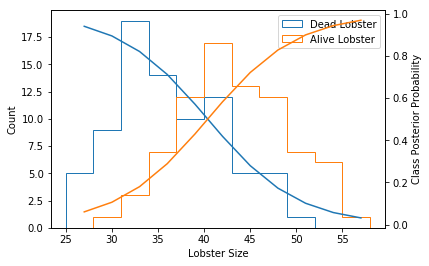

In [5]:
plt.hist(X[Y==0],label='Dead Lobster',bins=np.arange(25,60,3),histtype='step')
plt.hist(X[Y==1],label='Alive Lobster',bins=np.arange(25,60,3),histtype='step')
plt.xlabel('Lobster Size')
plt.ylabel('Count')
plt.legend()

ax2 = plt.twinx()
ax2.plot(X,class_posterior[:,0])
ax2.plot(X,class_posterior[:,1])
ax2.set_ylabel('Class Posterior Probability')
plt.show()
